<div style="text-align: center"> <h1>Stroke Model</h1></div>

This project will focus on building a stroke model. A stroke is when there is an abrupt disruption of blood flow to the brain. This is caused by blood vessel blockage, narrowing or bursting. According to the Nation Institutes of Health (NIH), nearly 800,000 Americans suffer a stroke every year, with some of these cases being fatal. If an individual survives a stroke, the neurological effects can be mild to severe, and may include cognitive decline, movement problems and emotional dysregulation. The NIH lists several risk factors for stroke, some of which are unmodifiable, and some can be modified. Building an accurate model of the risk factors involved in stroke could help craft guidelines for preventing strokes.


#### Stroke Background Information
U.S. Department of Health and Human Services. (2023, June 12). Stroke. National Institute of Neurological Disorders and Stroke. https://www.ninds.nih.gov/healthinformation/disorders/stroke 

#### Stroke Dataset
Fedesoriano. (2020). Stroke Prediction Dataset. Retrieved August 17, 2023 from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.


## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn


## Read in Data

In [3]:
# Import data
stroke = pd.read_csv("data/healthcare-dataset-stroke-data.csv")


## Initial Data Exploration

In [5]:
# Examine data
print(stroke.head())
print(stroke.info())
print(stroke.describe())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

The code below will print out which variables are numeric and which are categorical.

In [9]:
numerical_vars = []
categorical_vars = []

for column in stroke.columns:
    if pd.api.types.is_numeric_dtype(stroke[column]) and len(stroke[column].unique()) > 2:
        numerical_vars.append(column)
    else:
        categorical_vars.append(column)
        
print("Numerical variables:", numerical_vars)
print("Categorical variables:", categorical_vars)

Numerical variables: ['id', 'age', 'avg_glucose_level', 'bmi']
Categorical variables: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']


### Explanation of Features

0. id: unique identifier
1. gender: "Male", "Female" or "Other"
2. age: individual's age
3. hypertension: 1 if the individual has hypertension 0 if not
4. heart_disease: 1 if the individual has heart disease 0 if not
5. ever_married: "No" or "Yes"
6. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
7. bmi: body mass index
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average blood glucose level 
10. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
11. stroke: 1 if the individual suffered a stroke and 0 if not


## Data Cleaning

I will first inspect the data for null values.

In [11]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in stroke.columns:
    string_null = np.array([x in a[2:] for x in stroke[c]])
    print(c, stroke[c].isnull().sum(), string_null.sum()) 

id 0 0
gender 0 0
age 0 0
hypertension 0 0
heart_disease 0 0
ever_married 0 0
work_type 0 0
Residence_type 0 0
avg_glucose_level 0 0
bmi 201 0
smoking_status 0 0
stroke 0 0


Drop entries with NA for BMI

In [13]:
stroke = stroke.dropna()
stroke.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

I will also inspect the categorical variables for unusual entries. 

In [15]:
print(stroke['gender'].unique())
print(stroke['ever_married'].unique())
print(stroke['work_type'].unique())
print(stroke['smoking_status'].unique())
print(stroke['Residence_type'].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
['Urban' 'Rural']


There variable gender has male, female and other. I will examine gender more closely. 

         id gender   age  hypertension  heart_disease ever_married work_type  \
3116  56156  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0  


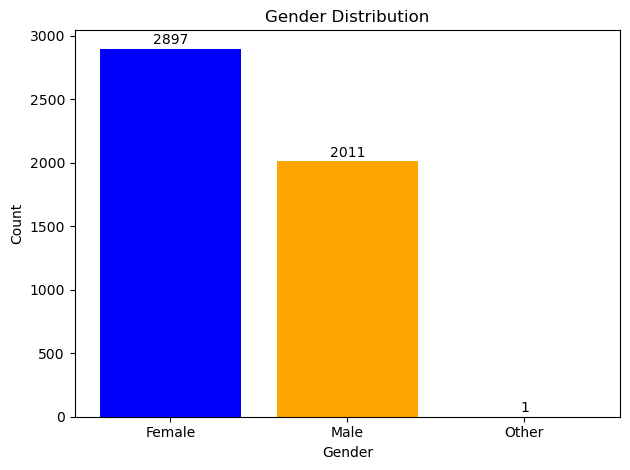

In [17]:
print(stroke[stroke['gender']=='Other'])

# bar plot of gender counts
gender_counts = stroke['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'orange', 'green'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.xticks(rotation=0)

# add count numbers above the bars
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('Gender Distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

There is only one instance of other in the category gender, so I will drop that data. 

In [19]:
# drop data
stroke.drop(stroke[stroke['gender']=="Other"].index,inplace=True)
# Check categories of gender variable 
stroke['gender'].value_counts()

gender
Female    2897
Male      2011
Name: count, dtype: int64

The variable smoking_status has a category Unknown, which I will now look at.

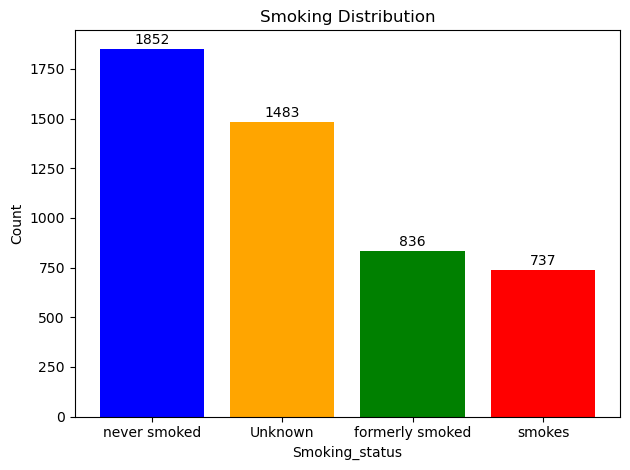

In [21]:
# bar plot of smoking_status counts
smoking_counts = stroke['smoking_status'].value_counts()
plt.bar(smoking_counts.index, smoking_counts.values, color=['blue', 'orange', 'green','red'])
plt.xlabel('Smoking_status')
plt.ylabel('Count')
plt.title('Smoking Distribution')
plt.xticks(rotation=0)

# add count numbers above the bars
for i, count in enumerate(smoking_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('Smoking Distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

'Unknown' entries for smoking status will be dropped.

In [23]:
stroke = stroke[stroke['smoking_status'] != 'Unknown']

Below I have also dropped the category id. It is a unique identifier for each individual and does not have any statistical meaning.

In [25]:
stroke = stroke.drop(columns = 'id')
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3425 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3425 non-null   object 
 1   age                3425 non-null   float64
 2   hypertension       3425 non-null   int64  
 3   heart_disease      3425 non-null   int64  
 4   ever_married       3425 non-null   object 
 5   work_type          3425 non-null   object 
 6   Residence_type     3425 non-null   object 
 7   avg_glucose_level  3425 non-null   float64
 8   bmi                3425 non-null   float64
 9   smoking_status     3425 non-null   object 
 10  stroke             3425 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 321.1+ KB


The Unknown category in the variable smoking_status has many entries, so I will not impute or drop any data based on this.

## Further Data Exploration
For this project stroke will be the response variable. This is a binary variable with 0 indicating a stroke has occured and 1 indicating no stroke has occured. In approximately 4.3 percent of the individuals a stroke has occurred and in approximately 95.7 percent of the individuals there was no indication of a stroke. 

Stroke Count: 180
No Stroke Count: 3245
stroke
0    94.744526
1     5.255474
Name: proportion, dtype: float64


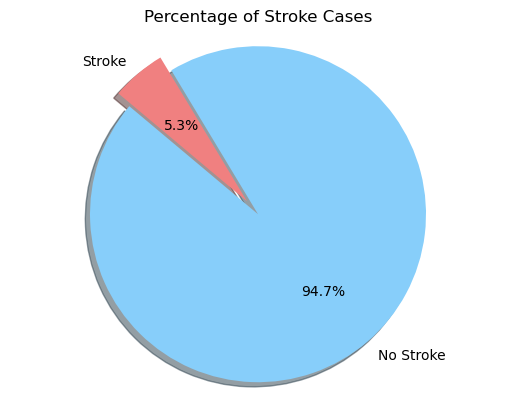

In [27]:
# Calculate the counts for stroke and no stroke
stroke_counts = stroke['stroke'].value_counts()
stroke_count = stroke_counts[1]
no_stroke_count = stroke_counts[0]

print(f"Stroke Count: {stroke_count}")
print(f"No Stroke Count: {no_stroke_count}")
print(stroke['stroke'].value_counts(normalize=True)*100)

# Calculate the percentage of stroke cases
stroke_percentage = (stroke['stroke'].value_counts(normalize=True) * 100).round(2)

# Create a pie chart
labels = ['No Stroke', 'Stroke']
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0) 
plt.pie(stroke_percentage, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of Stroke Cases')
plt.axis('equal')  
plt.savefig('results/stroke_percentage.png', dpi = 300, bbox_inches = 'tight')
plt.show()


### Exploration of Continuous Varaibles

#### Age

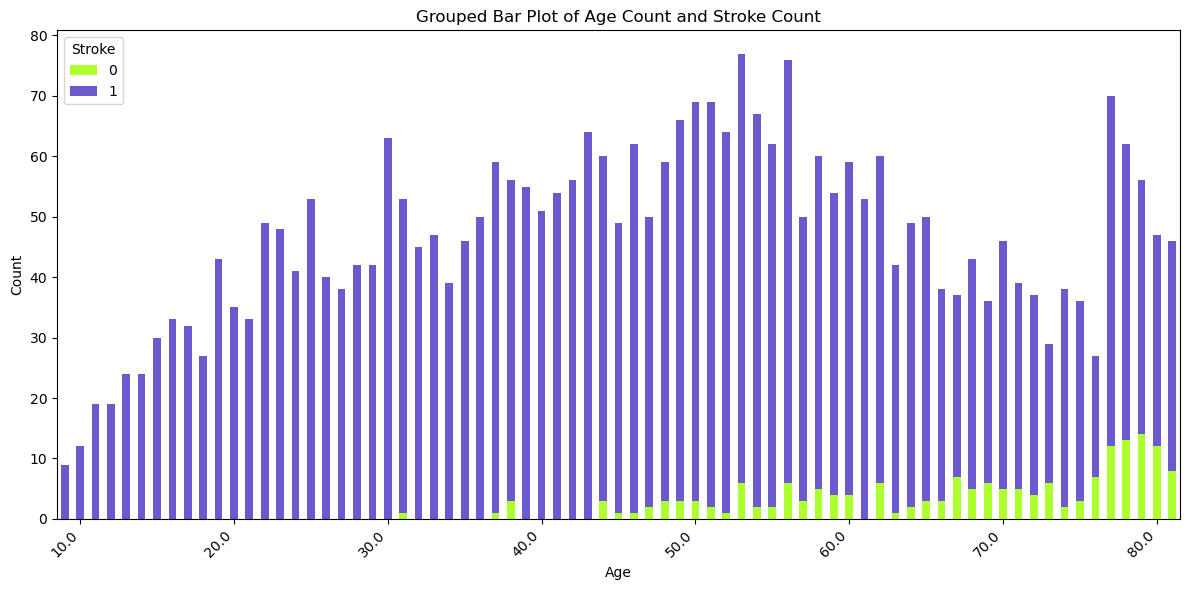

In [29]:
# Group the data by age and stroke, then calculate counts
age_stroke_counts = stroke.groupby(['age', 'stroke']).size().unstack()

# Swap the order of the columns for better visualization 
age_stroke_counts[[0, 1]] = age_stroke_counts[[1, 0]]

# Plot the grouped bar plot 
age_stroke_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['greenyellow', 'slateblue'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Grouped Bar Plot of Age Count and Stroke Count')
plt.legend(title='Stroke')
# Adjust x-axis tick positions and labels
plt.xticks(range(1, len(age_stroke_counts), 10), age_stroke_counts.index[::10], rotation=45, ha="right")

plt.tight_layout()
plt.savefig('results/age_stroke_distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### BMI

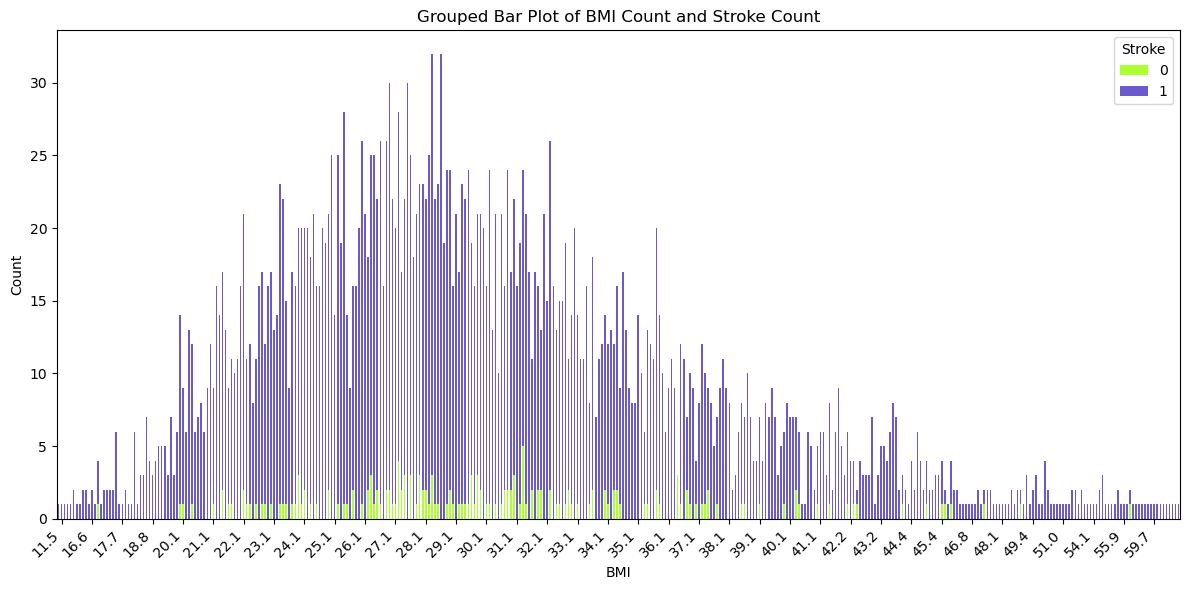

In [31]:
# Group the data by bmi and stroke, then calculate counts
bmi_stroke_counts = stroke.groupby(['bmi', 'stroke']).size().unstack()

# Swap the order of the columns for better visualization 
bmi_stroke_counts[[0, 1]] = bmi_stroke_counts[[1, 0]]

# Plot the grouped bar plot 
bmi_stroke_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['greenyellow', 'slateblue'])
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('Grouped Bar Plot of BMI Count and Stroke Count')
plt.legend(title='Stroke')
# Adjust x-axis tick positions and labels
plt.xticks(range(1, len(bmi_stroke_counts), 10), bmi_stroke_counts.index[::10], rotation=45, ha="right")

plt.tight_layout()
plt.savefig('results/bmi_stroke_distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

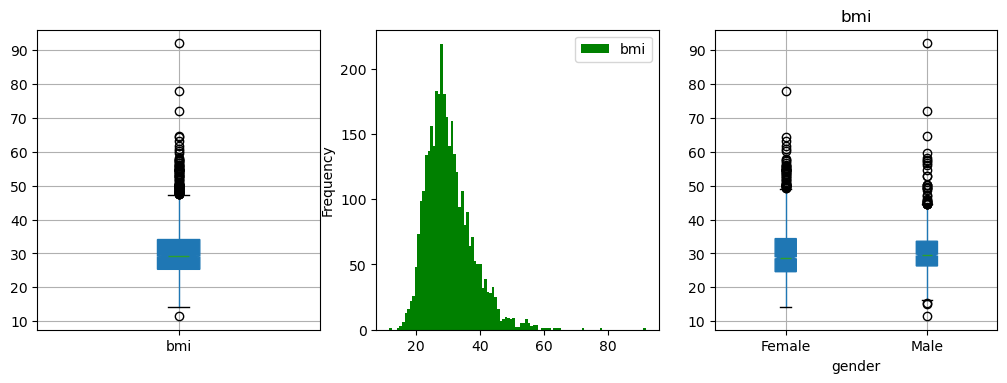

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
stroke.boxplot(column=['bmi'],patch_artist=True, notch=True, ax=axes[0])
plt.title('BMI Boxplot')

stroke.plot(kind="hist", y="bmi", bins=100, color="green", ax=axes[1])

stroke.boxplot(column=['bmi'],patch_artist=True, by='gender', notch=True, ax=axes[2])
plt.suptitle('')
plt.savefig('results/bmi_outliers.png', dpi = 300, bbox_inches = 'tight')
plt.show()

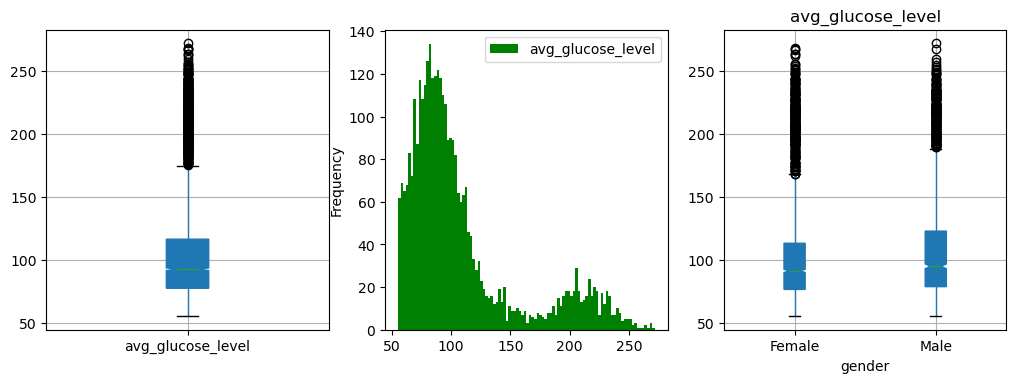

In [35]:
ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
stroke.boxplot(column=['avg_glucose_level'], patch_artist=True, notch=True, ax=axes[0])
plt.title('Glucose Level Boxplot')

stroke.plot(kind="hist", y="avg_glucose_level", bins=100, color="green", ax=axes[1])

stroke.boxplot(column=['avg_glucose_level'], patch_artist=True, by='gender', notch=True, ax=axes[2])
plt.suptitle('')
plt.savefig('results/glucose_level_outliers.png', dpi = 300, bbox_inches = 'tight')
plt.show()


### Exploration of Categorical Variables

Below is a function that will normalize the categorical variable and plot the percentage of each category that has and has not experienced a stroke. This will help identify variables that may have an increased association with stroke.

In [37]:
# Define a function to create a bar plot with percentages on bars
def plot_percentage_bar(data, x_col, y_col, xlabel, ylabel, title):
    grouped = data.groupby(x_col)[y_col].value_counts(normalize=True).unstack().fillna(0)
    ax = grouped.plot(kind='bar', stacked=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    for container in ax.containers:
        for p in container.patches:
            total = p.get_height()
            if p.get_y() < 0:  # If the bar is for 'stroke' category
                ax.annotate(f'{total*100:.1f}%', 
                            (p.get_x() + p.get_width() / 2., p.get_y() + total), 
                            ha='center', va='bottom', fontsize=10, color='black')
            else:  # If the bar is for 'no stroke' category
                ax.annotate(f'{total*100:.1f}%', 
                            (p.get_x() + p.get_width() / 2., p.get_y()), 
                            ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(rotation=0)
    plt.legend(title=y_col)
    plt.tight_layout()
    plt.savefig('Stroke Percentage by Category.png', dpi = 300, bbox_inches = 'tight')
    plt.show()


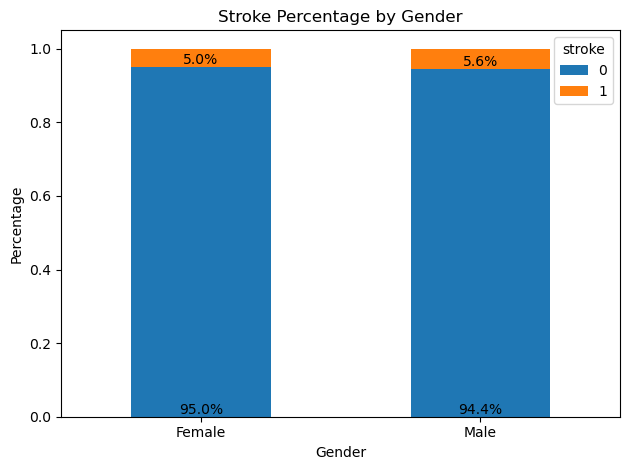

In [39]:
# Gender and Stroke Percentage
plot_percentage_bar(stroke, 'gender', 'stroke', 'Gender', 'Percentage', 'Stroke Percentage by Gender')


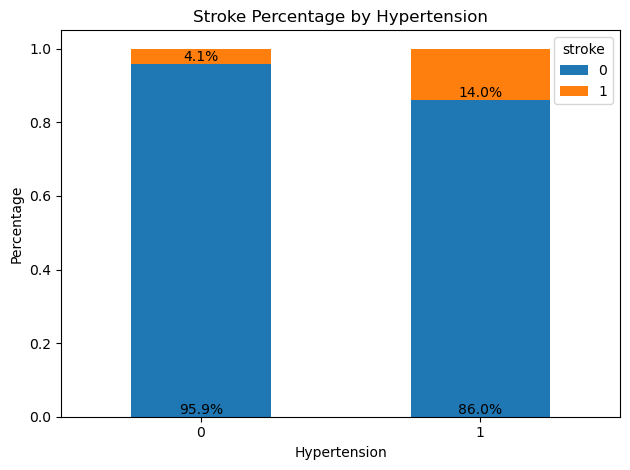

In [41]:
# Hypertension and Stroke Percentage
plot_percentage_bar(stroke, 'hypertension', 'stroke', 'Hypertension', 'Percentage', 'Stroke Percentage by Hypertension')

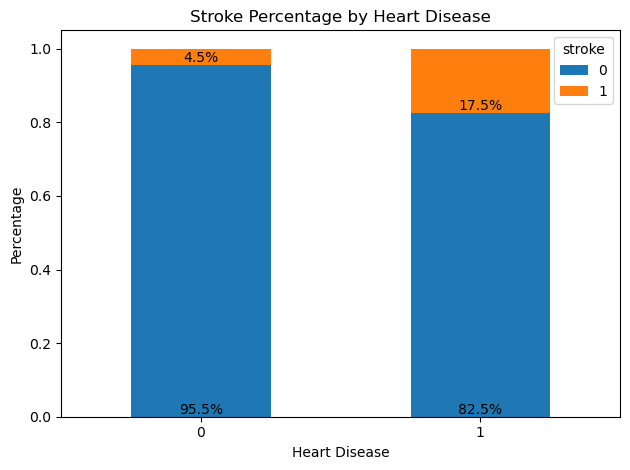

In [43]:
# Heart Disease and Stroke Percentage
plot_percentage_bar(stroke, 'heart_disease', 'stroke', 'Heart Disease', 'Percentage', 'Stroke Percentage by Heart Disease')

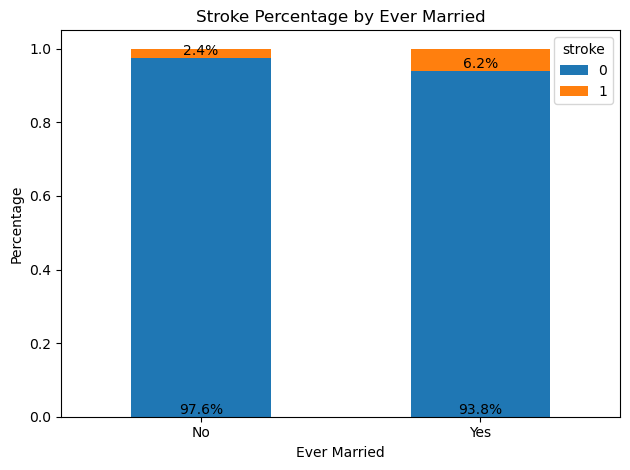

In [45]:
# Ever Married and Stroke Percentage
plot_percentage_bar(stroke, 'ever_married', 'stroke', 'Ever Married', 'Percentage', 'Stroke Percentage by Ever Married')

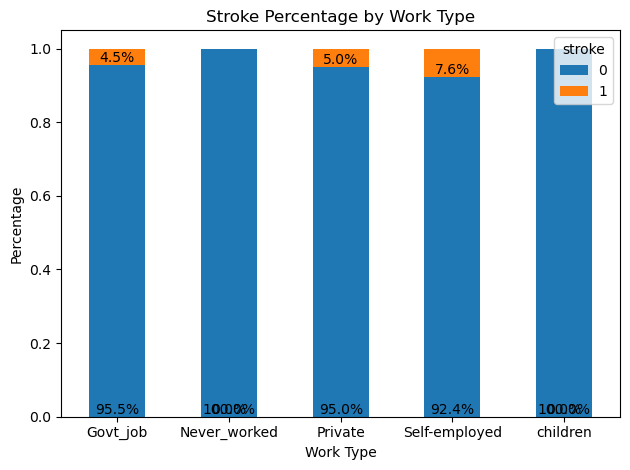

In [47]:
# Work Type and Stroke Percentage
plot_percentage_bar(stroke, 'work_type', 'stroke', 'Work Type', 'Percentage', 'Stroke Percentage by Work Type')

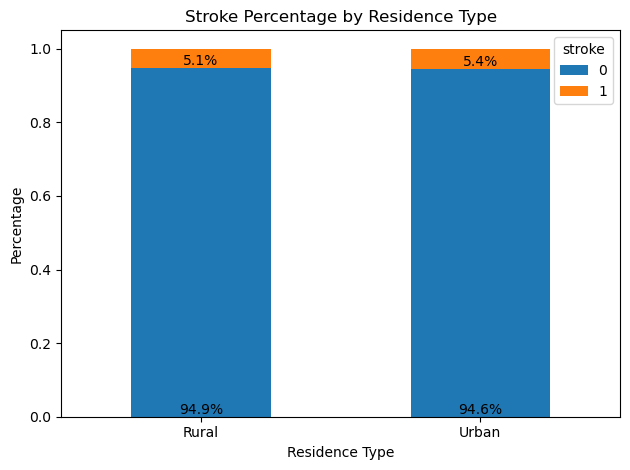

In [49]:
# Residence Type and Stroke Percentage
plot_percentage_bar(stroke, 'Residence_type', 'stroke', 'Residence Type', 'Percentage', 'Stroke Percentage by Residence Type')

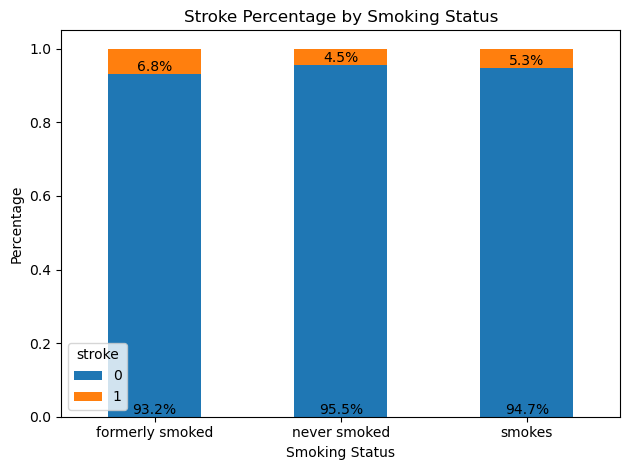

In [51]:
# Smoking Status and Stroke Percentage
plot_percentage_bar(stroke, 'smoking_status', 'stroke', 'Smoking Status', 'Percentage', 'Stroke Percentage by Smoking Status')


In [56]:
# Convert categorical variables to dummy variables 
stroke = pd.get_dummies(stroke, drop_first=True)
stroke.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,True,False,True,False,False,True,False,False
2,80.0,0,1,105.92,32.5,1,True,True,False,True,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,False,True,False,True,False,False,True,False,True
4,79.0,1,0,174.12,24.0,1,False,True,False,False,True,False,False,True,False
5,81.0,0,0,186.21,29.0,1,True,True,False,True,False,False,True,False,False


In [58]:
# Convert 'True' and 'False' enties to numeric '1' and '0'
bool_cols = ['gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 
             'work_type_Private', 'work_type_Self-employed', 'work_type_children', 
             'Residence_type_Urban','smoking_status_never smoked', 'smoking_status_smokes']

stroke[bool_cols] = stroke[bool_cols].astype(int)

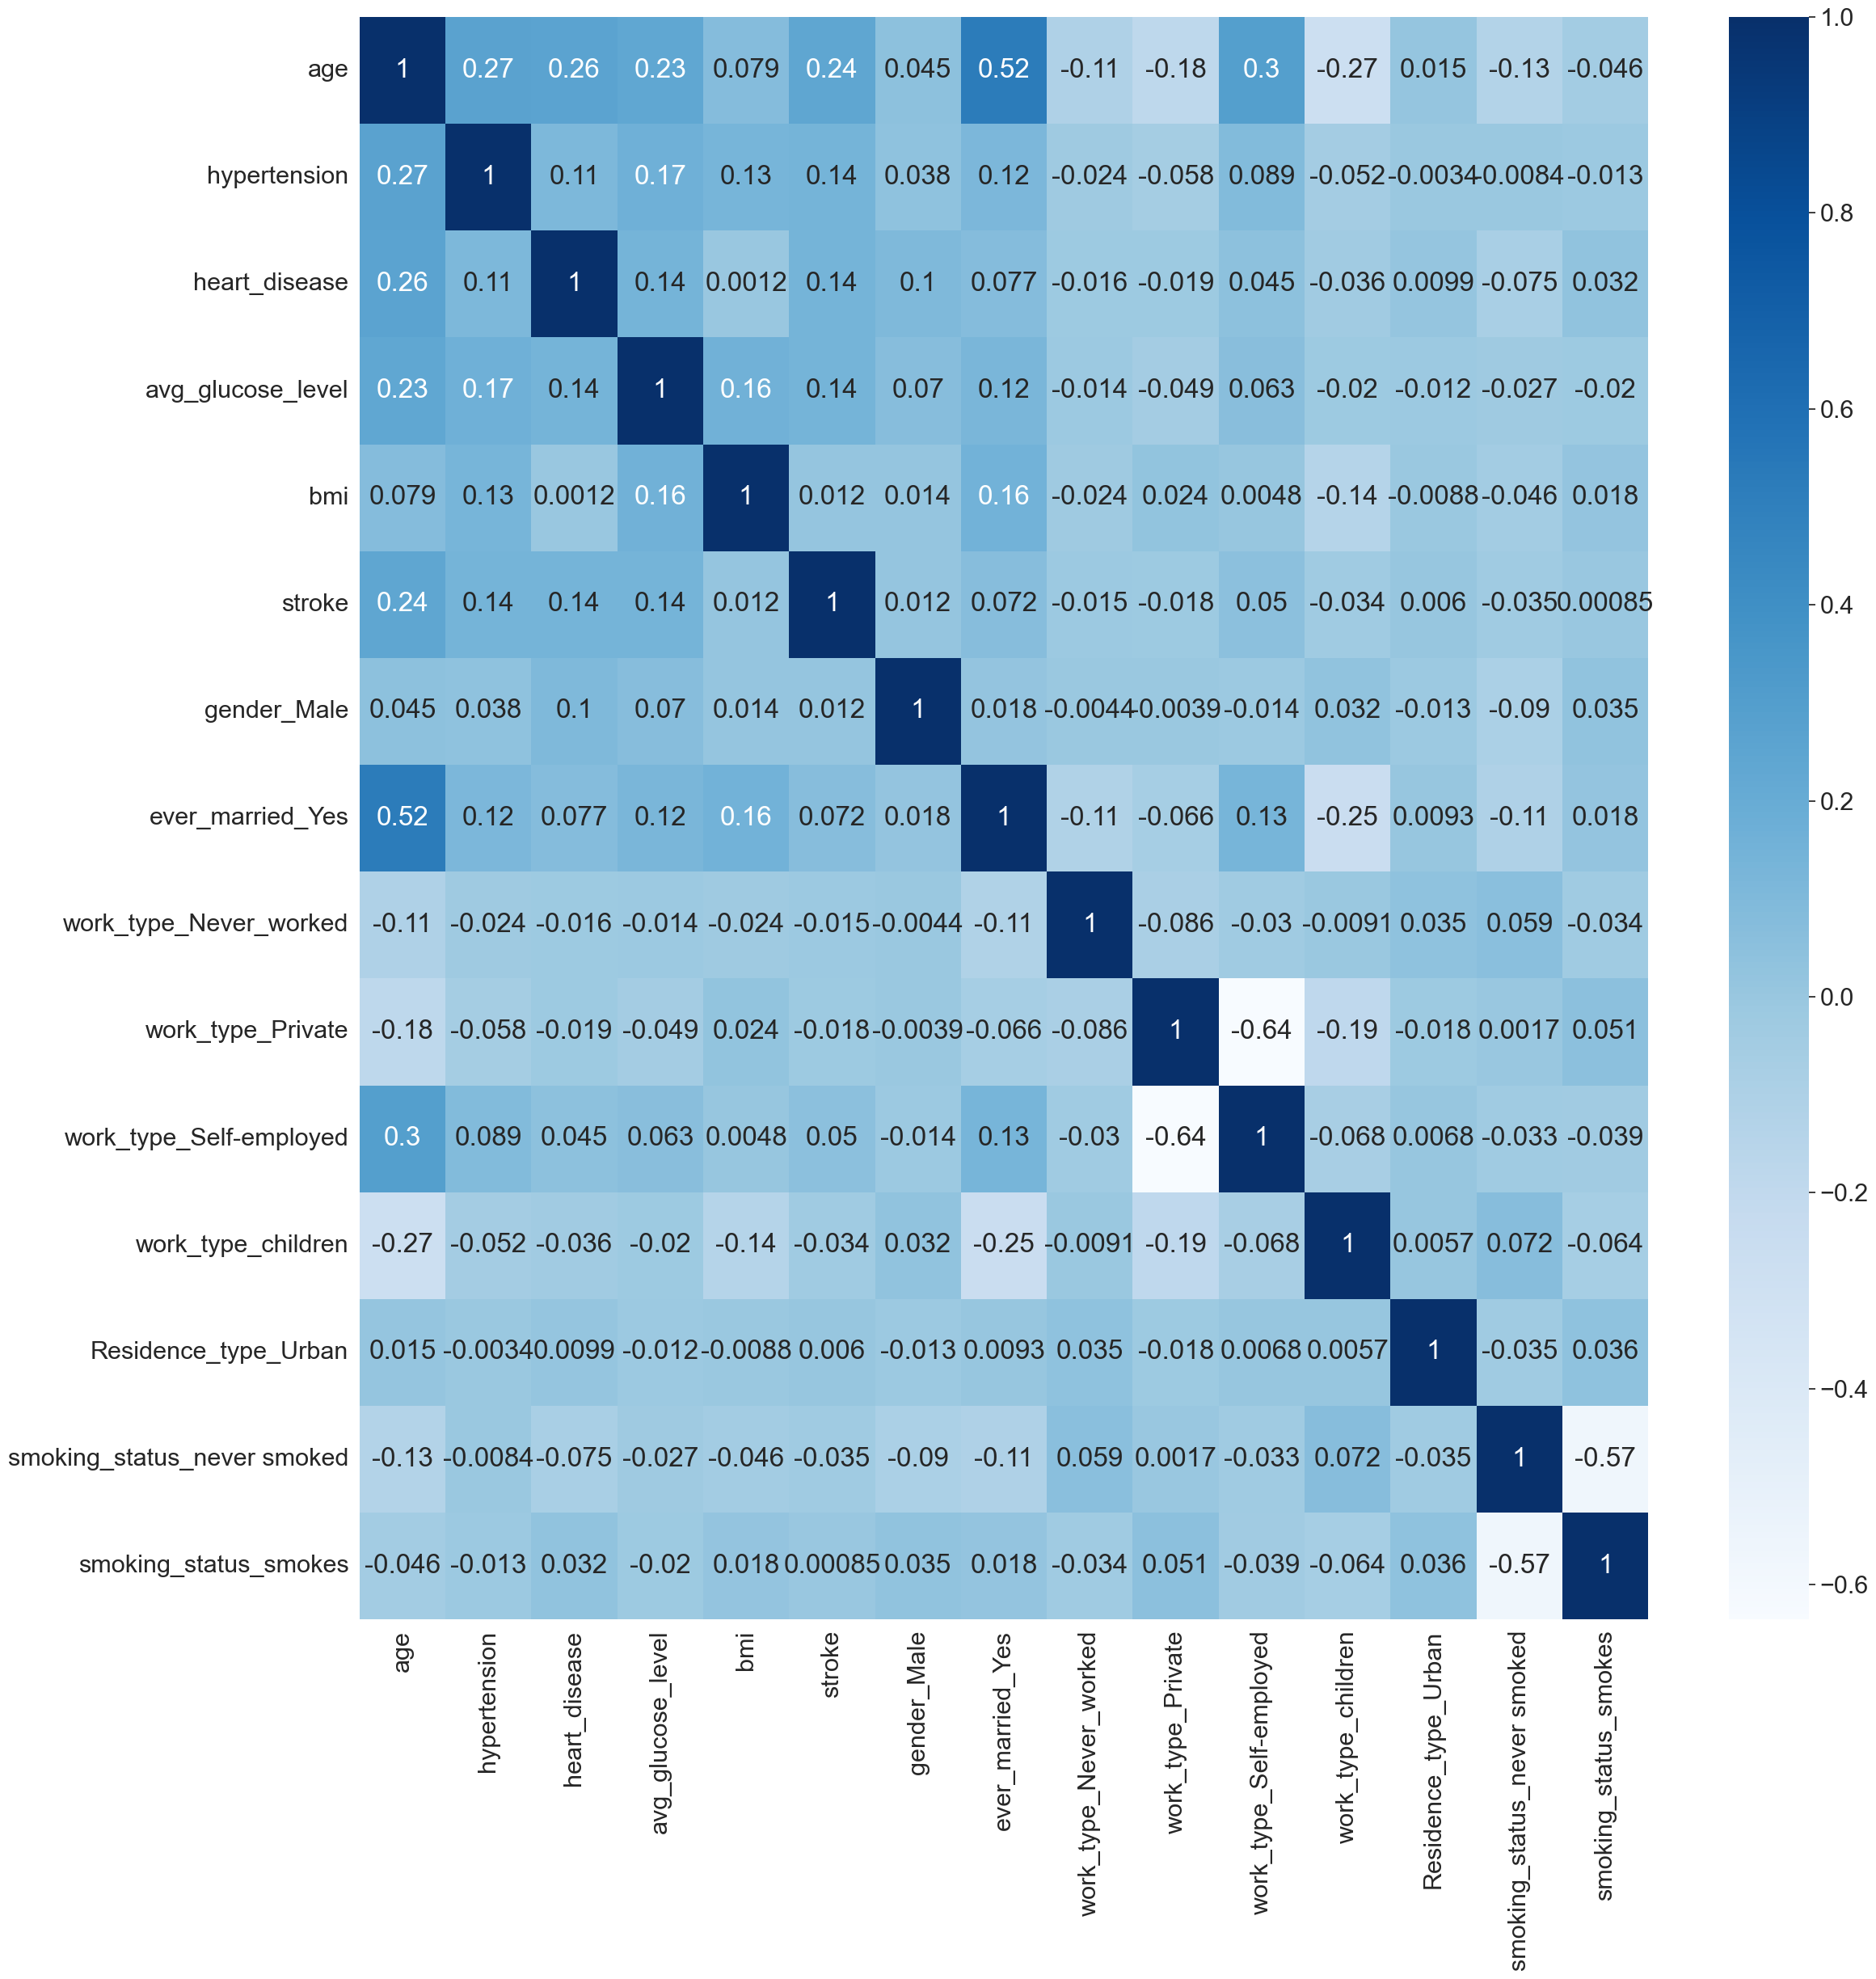

In [68]:
# correlation matrix plot
corr_matrix = stroke.corr()
fig, ax = plt.subplots(figsize=(25,25))
sns.set(font_scale=2)
sns.heatmap(corr_matrix, cmap="Blues", annot=True)
plt.tight_layout()
plt.savefig('results/correlation_matrix.png', dpi = 300, bbox_inches = 'tight')
plt.show()

I will export the cleaned data as a csv and use a new notebook to build the models.

In [70]:
stroke_clean = stroke
stroke_clean.to_csv("data/stroke_clean.csv", index=False)